In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings("ignore")

# Read Data
## Combine all the datasets in one

In [19]:
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

def load_data(path, source_label):
    df = pd.read_csv(path, header=None, names=columns, na_values='?',encoding='latin1')
    df['source'] = source_label
    return df

df_clev = load_data('Data/processed.cleveland.data', 'cleveland')
df_hung = load_data('Data/reprocessed.hungarian.data', 'hungarian')
df_sw = load_data('Data/processed.switzerland.data', 'switzerland')
df_va = load_data('Data/processed.va.data', 'va')

df = pd.concat([df_clev, df_hung, df_sw, df_va], ignore_index=True)
df.dropna(inplace=True)
df['target'] = df['target'].astype(float).apply(lambda x: 1 if x > 0 else 0).astype(float)

In [20]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,source
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0,cleveland
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1.0,cleveland
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0,cleveland
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0,cleveland
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0,cleveland


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 748
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       298 non-null    object 
 1   sex       298 non-null    float64
 2   cp        298 non-null    float64
 3   trestbps  298 non-null    float64
 4   chol      298 non-null    float64
 5   fbs       298 non-null    float64
 6   restecg   298 non-null    float64
 7   thalach   298 non-null    float64
 8   exang     298 non-null    float64
 9   oldpeak   298 non-null    float64
 10  slope     298 non-null    float64
 11  ca        298 non-null    float64
 12  thal      298 non-null    float64
 13  target    298 non-null    float64
 14  source    298 non-null    object 
dtypes: float64(13), object(2)
memory usage: 37.2+ KB


In [22]:
df.describe()

,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,0.677852,3.161074,131.654362,246.855705,0.144295,0.993289,149.500000,0.328859,1.057047,1.604027,0.674497,4.738255,0.463087
std,0.468085,0.964467,17.745811,52.607075,0.351980,0.994914,22.967002,0.470589,1.164443,0.617574,0.938202,1.939822,0.499474
min,0.000000,1.000000,94.000000,100.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,1.000000,3.000000,130.000000,242.500000,0.000000,1.000000,152.500000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,1.000000,4.000000,140.000000,275.750000,0.000000,2.000000,165.750000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


## y_hat = w0 + w1x1 + w2x2 ... + wpxp
### x = 'target'
#### drop target for features

In [23]:
target_name = 'target'
features = list(df.columns.drop(['target', 'source']))

In [24]:
X = df[features]
y = df[target_name]

### test = 20%
### train = 80%

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, shuffle=True)

### Scaling as LogReg using gradient descent for learning

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Using Regularization l2 (Ridge Regression(no features selection)) 100 lambda values, 5 fold cross validation, balance class weight

In [27]:
alphas = np.logspace(-3,3, num =100)
clf = LogisticRegressionCV(penalty = 'l2', Cs=alphas, cv=5, class_weight='balanced', max_iter=1000, random_state=42)

# Train the model

In [28]:
clf.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1.41747416e-02,
       1.62975083e-02, 1.87...
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                     class_weight='balanced', cv=5, max_iter=1000,
                     random_state=42)

# Bias(w0)

In [29]:
clf.intercept_

array([0.01580965])

# Coefficients(w1... wp)

In [30]:
clf.coef_

array([[ 0.08066204,  0.15658372,  0.24171267,  0.06928223,  0.00886902,
        -0.03503764,  0.09088384, -0.21621399,  0.20218749,  0.16664834,
         0.09457423,  0.23934706,  0.27889632]])

In [31]:
# Predicting on training set
y_pred = clf.predict(X_train_scaled)
# Predicting on test set
y_pred_test = clf.predict(X_test_scaled)

### Evaluation: Accuracy, F1, Confusion Matrix

#### Train set

=== Heart Disease Diagnosis Logistic Regression ===
Accuracy: 0.8487394957983193
F1: 0.8421052631578947
Confusion Matrix:
[[106  13]
 [ 23  96]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       119
         1.0       0.88      0.81      0.84       119

    accuracy                           0.85       238
   macro avg       0.85      0.85      0.85       238
weighted avg       0.85      0.85      0.85       238



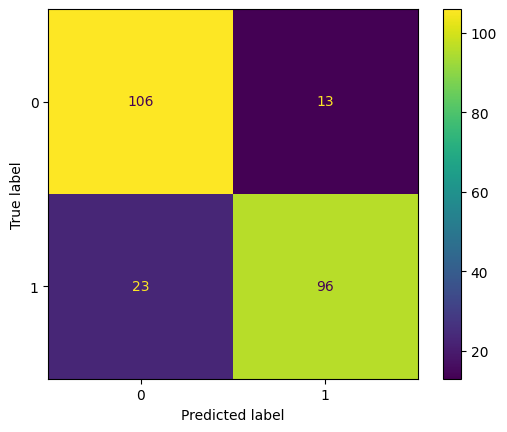

In [32]:
acc = accuracy_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
cm = confusion_matrix(y_train, y_pred)
print("=== Heart Disease Diagnosis Logistic Regression ===")
print("Accuracy:", acc)
print("F1:", f1)
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

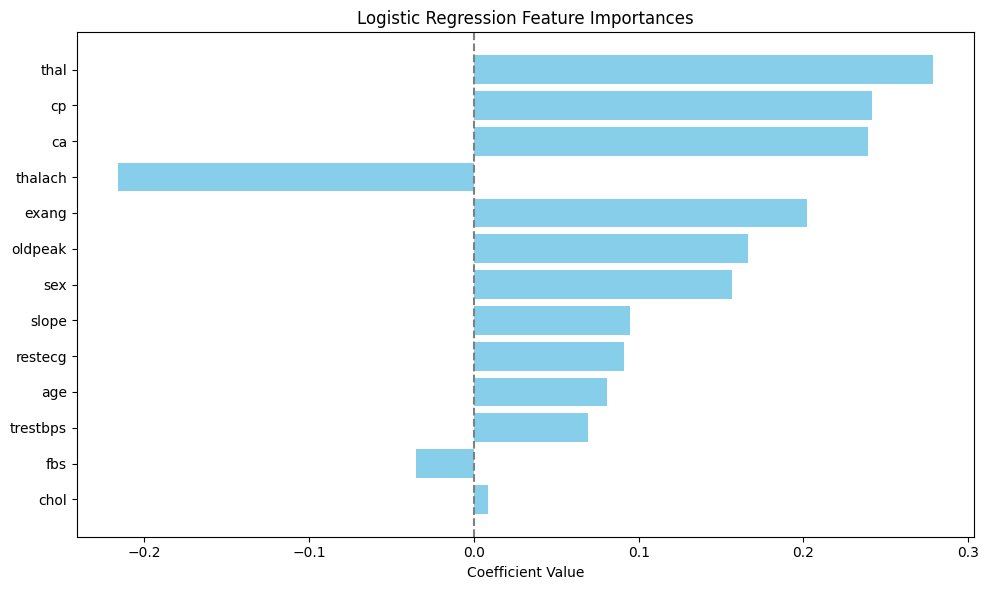

In [33]:
coefficients = clf.coef_[0]
feature_names = X.columns

# Create a DataFrame for easy sorting/plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
importance_df['AbsCoeff'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='AbsCoeff', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Coefficient'], color='skyblue')
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Logistic Regression Feature Importances')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

#### Test set

=== Reduced Feature Set Logistic Regression ===
Accuracy with Reduced Features: 0.85
F1 with Reduced Features: 0.7692307692307692
Confusion Matrix with Reduced Features:
[[36  5]
 [ 4 15]]


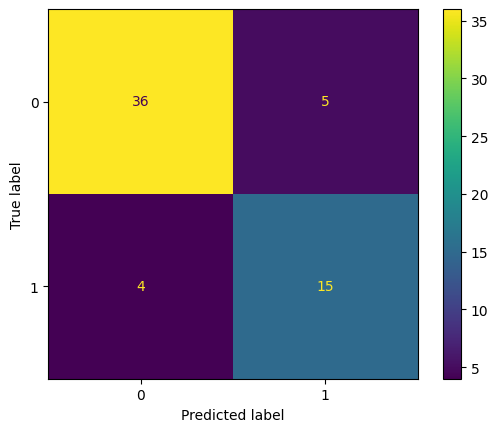

In [34]:
x_reduced = X_train_scaled[:, importance_df['AbsCoeff'] > 0.1]
x_reduced_test = X_test_scaled[:, importance_df['AbsCoeff'] > 0.1]
clf_reduced = LogisticRegressionCV(penalty='l2', Cs=alphas, cv=5, class_weight='balanced', max_iter=1000, random_state=42)
clf_reduced.fit(x_reduced, y_train)
y_pred_reduced = clf_reduced.predict(x_reduced_test)
acc_reduced = accuracy_score(y_test, y_pred_reduced)
f1_reduced = f1_score(y_test, y_pred_reduced)
print("=== Reduced Feature Set Logistic Regression ===")
print("Accuracy with Reduced Features:", acc_reduced)
print("F1 with Reduced Features:", f1_reduced)
cm_reduced = confusion_matrix(y_test, y_pred_reduced)
print("Confusion Matrix with Reduced Features:")
print(confusion_matrix(y_test, y_pred_reduced))
disp_reduced = ConfusionMatrixDisplay(confusion_matrix=cm_reduced)
disp_reduced.plot()


### Save trained model & scaler

In [35]:
import joblib

# Save your trained model
joblib.dump(clf, 'ridge_model.pkl')


['ridge_model.pkl']

In [36]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']